# Module 1 Project: King County House Sales Price Projection


# Part I: Obtain the data and data scrubbing



* Cast columns to the appropriate data types
* Identify and deal with null values appropriately
* Remove unnecessary columns
* Check for and deal with multicollinearity
* Normalize our data


In [113]:
#import libraries and data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from collections import Counter

In [114]:
kcdata = pd.read_csv("kc_house_data.csv")

In [115]:
kcdata.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [116]:
kcdata.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

## Deal with missing values

In [117]:
#Find missing value: waterfront, view, yr_renovated, and incorrect data type: sqft_basement
kcdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [118]:
kcdata['sqft_basement'].unique();

In [119]:
#For Categorical data 'Waterfront', replace NAN with 0 since it is highly possible that the house doesn't have a waterfront. 
kcdata['waterfront'].unique()
kcdata['waterfront'] = kcdata['waterfront'].fillna(0)

counter = Counter()
counter = Counter(kcdata['waterfront'])
print(counter)

Counter({0.0: 21451, 1.0: 146})


For view, this variable presents how many times people have viewed the house. Based on common sense, number of times being viewed should not decide the house price. Plus, majority of the values are zero. So we will replace NAN with 0 now and create bins: {0: nobody viewed, 1-2, 3-4}

In [120]:
kcdata['view'].unique()
kcdata['view'] = kcdata['view'].fillna(0)
counter = Counter()
counter = Counter(kcdata['view'])
print(counter)


Counter({0.0: 19485, 2.0: 957, 3.0: 508, 1.0: 330, 4.0: 317})


In [121]:
#There are too many missing values in yr_renovated. And it may not be fair to replace NAN with average. 
#So we will probably not consider this variable into the model.We will fill NaN and remove this column now.
%matplotlib inline
kcdata['yr_renovated'].fillna(0);
kcdata = kcdata.drop('yr_renovated', axis =1);
#kcdata['yr_renovated'].hist()

In [122]:
kcdata.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.006760,0.233181,3.409825,7.657915,1788.596842,1970.999676,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.081944,0.764673,0.650546,1.173200,827.759761,29.375234,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [123]:
kcdata.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Cast columns to the appropriate data types

Obvious fix: change date from string to datetime, sqft_basement to continuous, waterfront as categorical

Condition and grade are ordinal variables with limited values. View and Floors have limited values too. Can group them into bins. 

In [124]:
#Convert strings into dates
from datetime import datetime
kcdata['date'].head()
f = lambda x: datetime.strptime(x,'%m/%d/%Y')
kcdata['date']=kcdata['date'].apply(f)
kcdata.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,98074,47.6168,-122.045,1800,7503


In [125]:
#Convert sqft_basement column from string to numerical
kcdata['sqft_basement'].value_counts()

#Replace ? with zeros for now.
kcdata['sqft_basement'] = kcdata['sqft_basement'].replace('?','0')


kcdata['sqft_basement'] = kcdata['sqft_basement'].astype(float)
kcdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(11)
memory usage: 3.3 MB


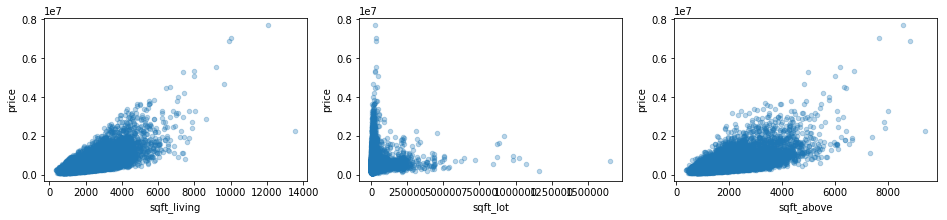

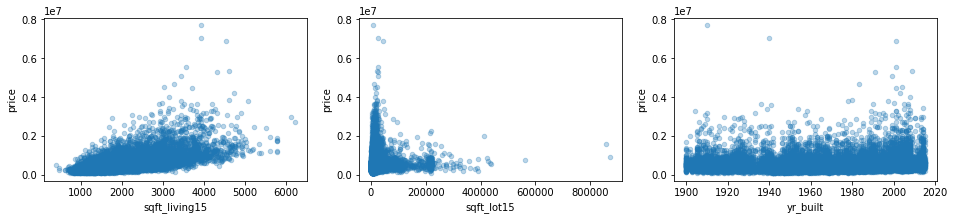

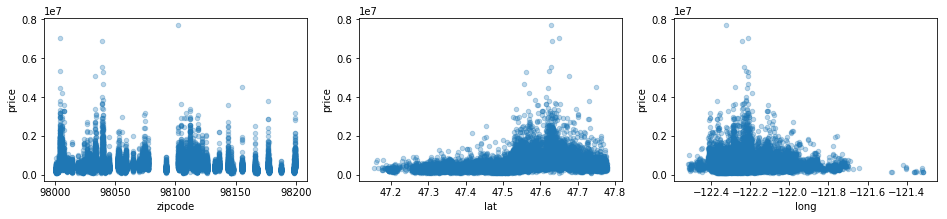

In [126]:
#Plotting potential continuous variables

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
con_list = ['sqft_living','sqft_lot','sqft_above']

for xcol, ax in zip(con_list, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
con_list2 =['sqft_living15','sqft_lot15','yr_built']

for xcol, ax in zip(con_list2, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3)
    
#Plotting zipcode

fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(16,3))
geo_list = ['zipcode','lat','long']

for xcol, ax in zip(geo_list, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3)


Observation: From the scattered plots above, we can tell sqft_living, sqft_above, sqft_living15 have positive correlation with house price, while yr_built and zipcode do not have obvious relationship with house price. Also from the plot, we can tell that the shape of sqft_living and sqft_living15 are similar while sqft_lot and sqft_lot15 are very similar too. So probably these two sets of variables are highly correlated.

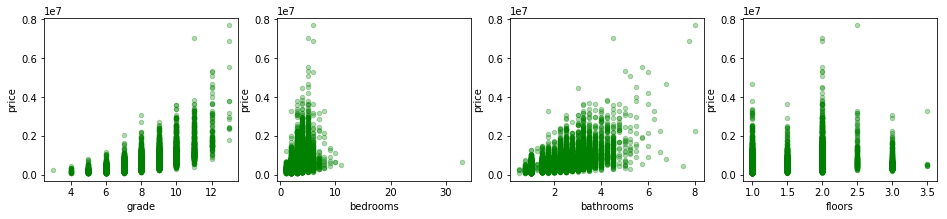

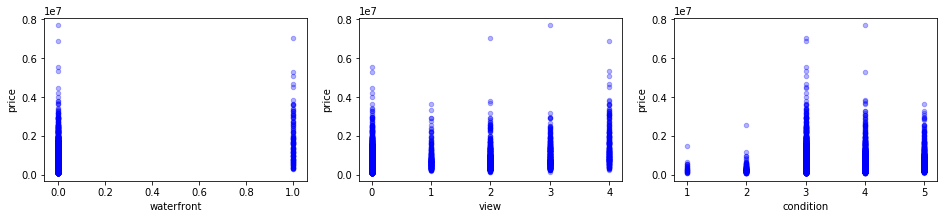

In [127]:
#Plotting other variables. Waterfront is clearly categorical values with binominal values. 
#While view, condition, grade, bedrooms, bathrooms, and floors present actual numerical values so we can either keep them numerical or transform them into categorical values. 

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
cat_list1 = ['grade','bedrooms', 'bathrooms','floors']


for xcol, ax in zip(cat_list1, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3, color='g')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))    
cat_list2=['waterfront', 'view', 'condition']
for xcol, ax in zip(cat_list2, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3, color='b')

## Turn condition to dummy columns

In [128]:

kcdata['view']=kcdata['view'].fillna(0)
kcdata['view'] = kcdata['view'].astype(int)


In [129]:
view_dummies = pd.get_dummies(kcdata['view'], prefix='view')


In [130]:
condition_dummies = pd.get_dummies(kcdata['condition'], prefix='con')

In [131]:
kcdata=pd.concat([kcdata,view_dummies,condition_dummies], axis=1)

In [132]:
kcdata[['condition','con_1','con_2','con_3','con_4','con_5']].head(20)

,condition,con_1,con_2,con_3,con_4,con_5
0,3,0,0,1,0,0
1,3,0,0,1,0,0
2,3,0,0,1,0,0
3,5,0,0,0,0,1
4,3,0,0,1,0,0
5,3,0,0,1,0,0
6,3,0,0,1,0,0
7,3,0,0,1,0,0
8,3,0,0,1,0,0
9,3,0,0,1,0,0


## Convert Waterfront to binominal 

In [133]:

kcdata['waterfront'] = kcdata['waterfront'].astype('category')
kcdata['waterfront'].cat.codes
waterfront_dummy = pd.get_dummies(kcdata['waterfront'], prefix ='waterfront')


## Create Bins for grade, bedrooms, bathrooms, years and floors

Although grade, bedrooms, bathrooms and floors are numerical values, it is diffidult to justify a linear pattern between these variables and target here. For example, grade 2 may not mean it is twice better than grade 1, or worse. It might make sense to restructure data into bins so that they are treated as categorical variables.

#### GRADE

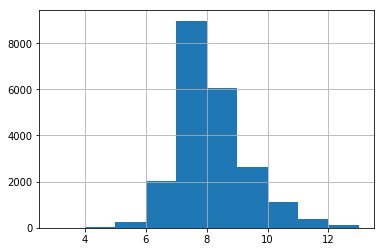

In [134]:
kcdata['grade'].describe()
kcdata['grade'].hist()

In [135]:
bins = [3,7,8,10,13]
bins_grade = pd.cut(kcdata['grade'],bins)

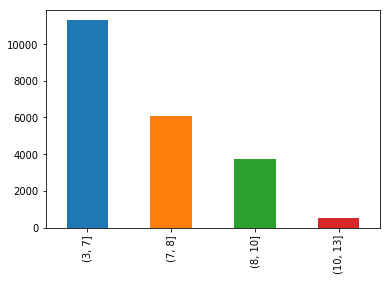

In [136]:
bins_grade.value_counts().plot(kind='bar')


In [137]:
bins_grade = bins_grade.cat.as_unordered()
grade_dummy = pd.get_dummies(bins_grade, prefix='grade')



#### BEDROOMS

In [138]:
kcdata['bedrooms'].describe()

count    21597.000000
mean         3.373200
std          0.926299
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

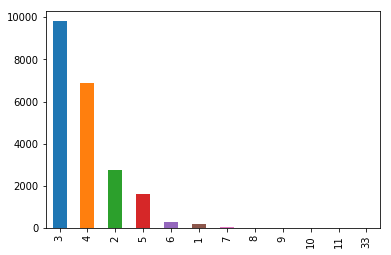

In [139]:
kcdata['bedrooms'].value_counts().plot(kind='bar')

There might be an outlier 33 in the bedroom variable. 

In [140]:
#The observation doesn't make sense, a house with 33 bedrooms only have 1040 sqft above the basement.
kcdata[kcdata['bedrooms']==33].sqft_above

15856    1040
Name: sqft_above, dtype: int64

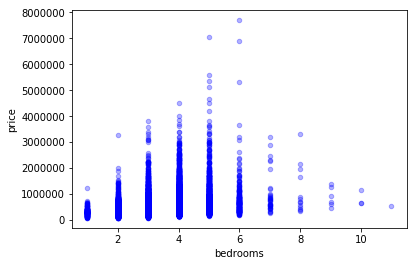

In [141]:
#Remove the max value from bedrooms
o = kcdata['bedrooms'].max()
kcdata = kcdata[kcdata['bedrooms']< o]
kcdata.plot(kind='scatter', x='bedrooms', y='price', alpha=0.3, color='b');


In [142]:
kcdata['bedrooms'].describe()

count    21596.000000
mean         3.371828
std          0.904114
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: bedrooms, dtype: float64

In [143]:
bins = [1,2,3,4,11]
bins_bedroom = pd.cut(kcdata['bedrooms'],bins)
bins_bedroom = bins_bedroom.cat.as_unordered()
bedroom_dummy = pd.get_dummies(bins_bedroom, prefix='bedroom')

#### BATHROOMS

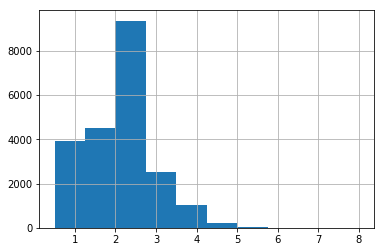

In [144]:
kcdata['bathrooms'].hist()
#kcdata['bathrooms'].value_counts();

The definition of 'bathrooms' is the number of bathrooms per bedrooms. Normally a residential building have 0.5-2 bathrooms per bedroom. So 3-8 bathrooms per bedroom may suggest there are different kinds of buildings. We can investigate the sqft_above and price to see if any outliers. 

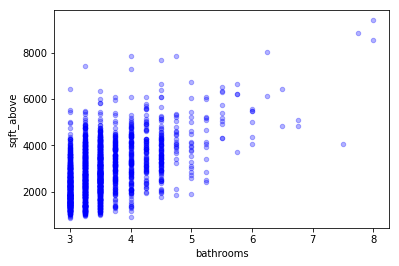

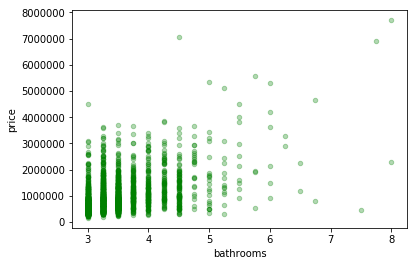

In [145]:
kcdata[kcdata['bathrooms']>=3].groupby('bathrooms').sqft_above.mean()
b = kcdata[kcdata['bathrooms']>=3]
b.plot(kind='scatter', x='bathrooms', y='sqft_above', alpha=0.3, color='b')
b.plot(kind='scatter', x='bathrooms', y='price', alpha=0.3, color='g')


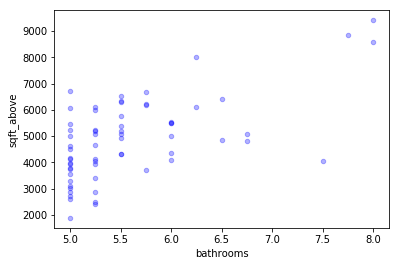

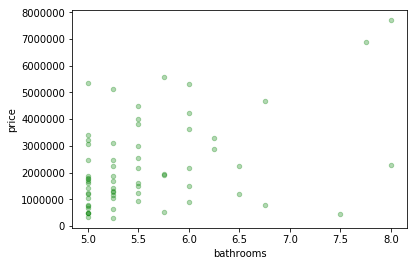

In [146]:
#Check bathrooms >5. 
kcdata[kcdata['bathrooms']>=5].groupby('bathrooms').sqft_above.mean()
a = kcdata[kcdata['bathrooms']>= 5]
a.plot(kind='scatter', x='bathrooms', y='sqft_above', alpha=0.3, color='b')
a.plot(kind='scatter', x='bathrooms', y='price', alpha=0.3, color='g')


We will create bins for bathrooms for now. 

In [147]:
bins = [0.5,1.5,2,2.5,5,8]
bins_bathroom = pd.cut(kcdata['bathrooms'],bins)
bins_bathroom = bins_bathroom.cat.as_unordered()
bathroom_dummy = pd.get_dummies(bins_bathroom, prefix='bathroom')

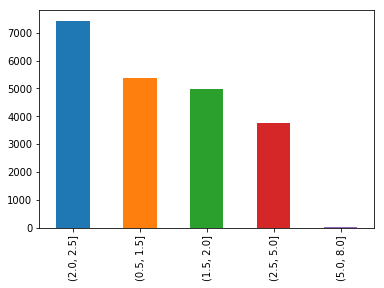

In [148]:
bins_bathroom.value_counts().plot(kind='bar')

#### FLOORS

In [149]:
kcdata['floors'].describe()

count    21596.000000
mean         1.494119
std          0.539685
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          3.500000
Name: floors, dtype: float64

In [150]:
bins = [0,1,1.5,2,3.5]
bins_floors = pd.cut(kcdata['floors'],bins)
bins_floors = bins_floors.cat.as_unordered()
floors_dummy = pd.get_dummies(bins_floors, prefix = 'floors')


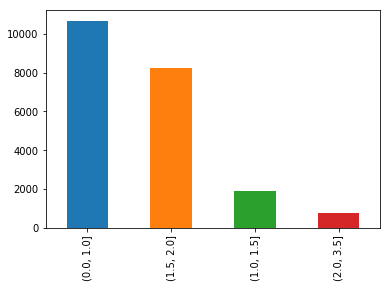

In [151]:
bins_floors.value_counts().plot(kind='bar')

#### Year Built

In [152]:
kcdata['yr_built'].describe()

count    21596.000000
mean      1971.000787
std         29.375460
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

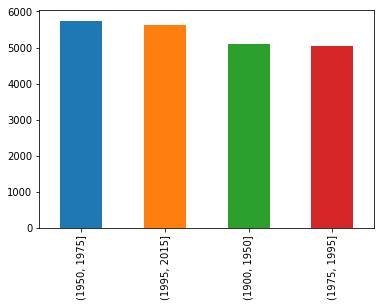

In [153]:
bins = [1900,1950,1975,1995,2015]
bins_year = pd.cut(kcdata['yr_built'],bins)
bins_year = bins_year.cat.as_unordered()
bins_year.head()
year_dummy=pd.get_dummies(bins_year, prefix='year')

bins_year.value_counts().plot(kind='bar')

In [ ]:
kcdata.hist(figsize=[15,15]);

## Correlation Matrix

In [ ]:
sns.set(context='paper', font='monospace')
corrmat = kcdata.corr()


f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.8, square=True);

Analyzing the heatmap, the variables that are highly correlated to price are:
* sqft_living
* sqft_above
* grade

Independent variables which are highly correlated with each other:

* sqft_living with sqft_living15, bathroom, grade, sqft_above
* grade with bathroom, sqft_above, sqft_living15, sqft_living

## Check Multicolinearity 

In [155]:
## Check Multicolinearity 

kcdata_set = kcdata.iloc[:,3:-1]
kcdata_set.head()
kcdata_set.corr()
abs(kcdata_set.corr()) > 0.75;

The correlation matrix confirms the observation that sqft_living are highly correlated with bathrooms, grade, sqft_above, sqft_living15.

Multicolinearity exists here.

We will drop sqft_living15, sqft_lot15 because they are highly correlated with sqft_living and sqft_lot, and also zipcode, lat, long.

## Feature Scaling and Normalization

In [160]:
#kcdata.info()

kcdata_set = kcdata.drop(columns=['bedrooms','bathrooms','floors','waterfront','grade','yr_built','view','condition','sqft_living15','sqft_lot15','zipcode','lat','long'],axis=1)

In [161]:
kcdata_set = pd.concat([kcdata_set,bedroom_dummy, bathroom_dummy, grade_dummy, waterfront_dummy, floors_dummy, year_dummy], axis=1)
kcdata_set.head()

,id,date,price,sqft_living,sqft_lot,sqft_above,sqft_basement,view_0,view_1,view_2,...,waterfront_0.0,waterfront_1.0,"floors_(0.0, 1.0]","floors_(1.0, 1.5]","floors_(1.5, 2.0]","floors_(2.0, 3.5]","year_(1900, 1950]","year_(1950, 1975]","year_(1975, 1995]","year_(1995, 2015]"
0,7.129301e+09,2014-10-13,221900.0,1180.0,5650.0,1180.0,0.0,1.0,0.0,0.0,...,1,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,6.414100e+09,2014-12-09,538000.0,2570.0,7242.0,2170.0,400.0,1.0,0.0,0.0,...,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,5.631500e+09,2015-02-25,180000.0,770.0,10000.0,770.0,0.0,1.0,0.0,0.0,...,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2.487201e+09,2014-12-09,604000.0,1960.0,5000.0,1050.0,910.0,1.0,0.0,0.0,...,1,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.954401e+09,2015-02-18,510000.0,1680.0,8080.0,1680.0,0.0,1.0,0.0,0.0,...,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [162]:
kcdata_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 0 to 21596
Data columns (total 40 columns):
id                     21596 non-null float64
date                   21596 non-null datetime64[ns]
price                  21596 non-null float64
sqft_living            21596 non-null float64
sqft_lot               21596 non-null float64
sqft_above             21596 non-null float64
sqft_basement          21596 non-null float64
view_0                 21596 non-null float64
view_1                 21596 non-null float64
view_2                 21596 non-null float64
view_3                 21596 non-null float64
view_4                 21596 non-null float64
con_1                  21596 non-null float64
con_2                  21596 non-null float64
con_3                  21596 non-null float64
con_4                  21596 non-null float64
con_5                  21596 non-null float64
bedroom_(1, 2]         21596 non-null float64
bedroom_(2, 3]         21596 non-null float64
bedroom_(3

 
Variables with lepto kurtosis: price, sqft_lot
Variables with either positive or negative Skewness: sqft_above, sqft_living

We will perform log transformation to variables with skewness and then do mean normalization. 

### Log Transformation on sqft_above and sqft_living

In [163]:
kcdata_log = pd.DataFrame([])
kcdata_log['sqft_above']=np.log(kcdata_set['sqft_above'])
kcdata_log['sqft_living']=np.log(kcdata_set['sqft_living'])
kcdata_log['price']=np.log(kcdata_set['price'])

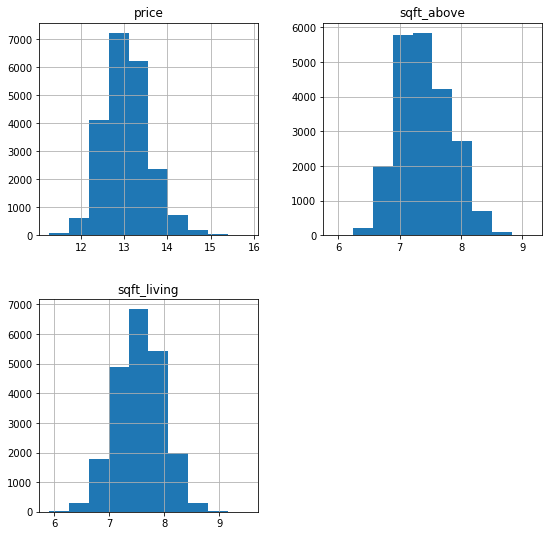

In [164]:
kcdata_log.hist(figsize=[9,9]);

In [165]:
basement = kcdata_set['sqft_basement']
lot = kcdata_set['sqft_lot']
logabove = kcdata_log['sqft_above']
logliving = kcdata_log['sqft_living']
logprice = kcdata_log['price']


scaled_basement= (basement - min(basement))/(max(basement) - min(basement))
scaled_lot = (lot - min(lot))/(max(lot) - min(lot))
scaled_above = (logabove - np.mean(logabove))/np.sqrt(np.var(logabove))
scaled_living = (logliving - np.mean(logliving))/np.sqrt(np.var(logliving))
scaled_price = (logprice - np.mean(logprice))/np.sqrt(np.var(logprice))


kcdata_set['price']=scaled_price
kcdata_set['sqft_living']=scaled_living
kcdata_set['sqft_above']=scaled_above
kcdata_set['sqft_lot']=scaled_lot
kcdata_set['sqft_basement']=scaled_basement



In [166]:
kcdata_set.head()

,id,date,price,sqft_living,sqft_lot,sqft_above,sqft_basement,view_0,view_1,view_2,...,waterfront_0.0,waterfront_1.0,"floors_(0.0, 1.0]","floors_(1.0, 1.5]","floors_(1.5, 2.0]","floors_(2.0, 3.5]","year_(1900, 1950]","year_(1950, 1975]","year_(1975, 1995]","year_(1995, 2015]"
0,7.129301e+09,2014-10-13,-1.401982,-1.125577,0.003108,-0.753633,0.000000,1.0,0.0,0.0,...,1,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,6.414100e+09,2014-12-09,0.279969,0.709431,0.004072,0.672662,0.082988,1.0,0.0,0.0,...,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,5.631500e+09,2015-02-25,-1.799418,-2.131918,0.005743,-1.753047,0.000000,1.0,0.0,0.0,...,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2.487201e+09,2014-12-09,0.499731,0.070657,0.002714,-1.026909,0.188797,1.0,0.0,0.0,...,1,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.954401e+09,2015-02-18,0.178463,-0.292744,0.004579,0.073468,0.000000,1.0,0.0,0.0,...,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
kcdata.info()

Resources: https://medium.com/vickdata/four-feature-types-and-how-to-transform-them-for-machine-learning-8693e1c24e80

## Part II: Exploratory Data Analysis

From the data dictionary below we can probably tell some are continuous variables (footage of the home/lot/basement/yr_built) and some might be numerical but more like categorical (number of bathrooms/bedrooms, waterfront, view, condition, grade), and other variables we are not sure (zipcode,lat,long). We will visualize them next.

* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

In [ ]:
#Value Counts 
#bathroomsNumber - of bathrooms/bedrooms

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
bathroom_count = kcdata['bathrooms'].value_counts()
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
sns.barplot(bathroom_count.index, bathroom_count.values, alpha=0.9)

plt.title('Frequency Distribution of Bathrooms')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of Bathrooms/Bedrooms', fontsize=12)
plt.show()

## Part III: Multi-regression Model

In [167]:
data_ols = kcdata_set.iloc[:,2:]
data_ols.dropna(inplace=True)

In [168]:
data_ols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 38 columns):
price                  21596 non-null float64
sqft_living            21596 non-null float64
sqft_lot               21596 non-null float64
sqft_above             21596 non-null float64
sqft_basement          21596 non-null float64
view_0                 21596 non-null float64
view_1                 21596 non-null float64
view_2                 21596 non-null float64
view_3                 21596 non-null float64
view_4                 21596 non-null float64
con_1                  21596 non-null float64
con_2                  21596 non-null float64
con_3                  21596 non-null float64
con_4                  21596 non-null float64
con_5                  21596 non-null float64
bedroom_(1, 2]         21596 non-null float64
bedroom_(2, 3]         21596 non-null float64
bedroom_(3, 4]         21596 non-null float64
bedroom_(4, 11]        21596 non-null float64
bathroom_(0.5, 1.

In [95]:
"""
outcome = 'price'
predictors = data_ols.drop('price', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum
"""


In [169]:
X = predictors
y = data_ols['price']

In [170]:
import statsmodels.api as sm
#from statsmodels.formula.api import ols

X_int = sm.add_constant(predictors)

model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     1616.
Date:                Mon, 13 May 2019   Prob (F-statistic):               0.00
Time:                        17:51:08   Log-Likelihood:                -19248.
No. Observations:               21596   AIC:                         3.855e+04
Df Residuals:                   21570   BIC:                         3.876e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              13.4225      0.494     27.180      0.000      12.455      14.390
bedrooms           -0.0691      0.023     -2.946      0.003      -0.115      -0.023
bathrooms           0.1467      0.010     15.378      0.000       0.128       0.165
sqft_living         0.3287      0.022     15.174      0.000       0.286       0.371
sqft_lot            0.1364      0.165      0.827      0.408      -0.187       0.460
floors              0.1793      0.010     17.165      0.000       0.159       0.200
grade               0.4246      0.011     38.034      0.000       0.403       0.446
sqft_above         -0.0353      0.020     -1.794      0.073      -0.074       0.003
sqft_basement       0.2776      0.119      2.341      0.019       0.045       0.510
yr_built           -0.0106      0.000    -56.595      0.000      -0.011      -0.010
view_0              2.3875      0.100     23.830      0.000       2.191       2.584
view_1              2.7189      0.103     26.489      0.000       2.518       2.920
view_2              2.5668      0.100     25.600      0.000       2.370       2.763
view_3              2.6439      0.101     26.111      0.000       2.445       2.842
view_4              3.1053      0.103     30.261      0.000       2.904       3.306
con_1               2.4916      0.134     18.605      0.000       2.229       2.754
con_2               2.4574      0.108     22.841      0.000       2.246       2.668
con_3               2.7607      0.102     26.953      0.000       2.560       2.961
con_4               2.7970      0.101     27.582      0.000       2.598       2.996
con_5               2.9158      0.100     29.021      0.000       2.719       3.113
bedroom_(1, 2]      0.0026      0.025      0.102      0.919      -0.047       0.052
bedroom_(2, 3]     -0.0679      0.032     -2.106      0.035      -0.131      -0.005
bedroom_(3, 4]     -0.0598      0.042     -1.431      0.152      -0.142       0.022
bedroom_(4, 11]    -0.0197      0.055     -0.362      0.717      -0.127       0.087
grade_(3, 7]       -0.6023      0.296     -2.032      0.042      -1.183      -0.021
grade_(7, 8]       -0.5966      0.297     -2.010      0.044      -1.179      -0.015
grade_(8, 10]      -0.5740      0.297     -1.930      0.054      -1.157       0.009
grade_(10, 13]     -0.6210      0.299     -2.078      0.038      -1.207      -0.035
bedroom_(1, 2]      0.0026      0.025      0.102      0.919      -0.047       0.052
bedroom_(2, 3]     -0.0679      0.032     -2.106      0.035      -0.131      -0.005
bedroom_(3, 4]     -0.0598      0.042     -1.431      0.152      -0.142       0.022
bedroom_(4, 11]    -0.0197      0.055     -0.362      0.717      -0.127       0.087
grade_(3, 7]       -0.6023      0.296     -2.032      0.042      -1.183      -0.021
grade_(7, 8]       -0.5966      0.297     -2.010      0.044

In [171]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [172]:
X = predictors
y = data_ols['price']

In [175]:
result = stepwise_selection(X, y, verbose = True)
print(result)

ValueError: No axis named 1 for object type <class 'pandas.core.series.Series'>

## Use sklearn

In [ ]:
#You have to use numerical values in sklearn... has to transform to dummy variables...
https://www.scikit-yb.org/en/latest/api/features/rfecv.html

In [177]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [178]:
linreg = LinearRegression()
selector = RFE(linreg,n_features_to_select=8)
selector = selector.fit(X,y)

In [185]:
selector.support_

array([False, False, False, False, False, False, False,  True, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
       False, False, False, False, False,  True,  True,  True])

In [186]:
estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)

[2.38101026 0.83215089 0.32642162 0.7343994  1.24224985 0.32642162
 0.7343994  1.24224985]
-0.6493081169550404


In [188]:
selected_columns = X.columns[selector.support_ ]
linreg.fit(X[selected_columns],y)
selected_columns

Index(['sqft_basement', 'view_4', 'grade_(7, 8]', 'grade_(8, 10]',
       'grade_(10, 13]', 'grade_(7, 8]', 'grade_(8, 10]', 'grade_(10, 13]'],
      dtype='object')

In [ ]:
"""


formula = "price ~ bedrooms + bathrooms + sqft_above + sqft_lot + sqft_basement + sqft_living + yr_built + grade + con_1+con_2+con_3+con_4+con_5"
model = ols(formula=formula, data = data_ols).fit()
model.summary()

"""

## Cross-Validation